# 1: Import Packages and Define Functions

In [266]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import sys
sys.path.insert(1, '/Users/brianmccabe/DataScience/Flatiron/mod5/Emoji_Analysis/Scripts/')
import config
import warnings
warnings.filterwarnings('ignore')



pd.set_option('display.max_columns', 300)

%matplotlib inline

In [267]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import string
import scipy
import emoji
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [268]:
def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.UNICODE_EMOJI)

In [269]:
def check_for_flags(s):
    s = str(s)
    has_flag = False
    for flag in flags:
        if flag in s:
            has_flag = True
    return has_flag

In [270]:
def unique_emoji_count(s):
    return len(set([c for c in s]))

In [271]:
def condence_emojis(s):
    try:
        return set(s).pop()
    except:
        return None

In [272]:
analyzer = SentimentIntensityAnalyzer()
def sentiment_scores(s):
    return analyzer.polarity_scores(s)['compound']

In [273]:
def remove_emojis(s):
    pattern = "\w+"
    return ' '.join(re.findall(pattern, s))

# 2: Load in the Data and Clean

In [274]:
connection = mysql.connector.connect(host=config.host,
                                         user=config.user,
                                         port=config.port,
                                         password=config.password,
                                         database=config.database,
                                         auth_plugin='mysql_native_password')

cursor = connection.cursor()
query = "SELECT tweet FROM Tweets WHERE HEX(tweet) RLIKE '^(..)*F.'"

df = pd.read_sql(query, connection)

In [275]:
df['emoji'] = df.tweet.apply(extract_emojis)

In [276]:
# We can see that emoji flags have strange representations. I will remove them from the dataset.
## NOTE BELOW LIKELY WILL NO LONGER SHOW A FLAG, SINCE I'VE BEEN PULLING DATA EVERY DAY
## But, flags were basically as follows....alone as a string, they are equal to a flag plus a white space
## HOWEVER, once you strip it apart into a list form, it becomes a list of two emoticon-characters
## For example, Brazil Flag as a string is "Flag ", but as a list, it is ["[B], [R]"]
## Below, i actually acquire these codes from wikipedia to aid in removing flags from the dataset
[c for c in df.emoji.loc[9]]

['🤍']

In [277]:
import flag
from bs4 import BeautifulSoup
import requests

In [278]:
url = 'https://en.wikipedia.org/wiki/Regional_indicator_symbol'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

In [279]:
flags = []
skip_first = 0
for item in soup.find('tbody').find_all('tr'):
    if skip_first == 0:
        skip_first += 1
        continue
    flagcode = item.find_all('td')[1].text
    flags.append(flag.flag(flagcode))

flags[0:5]    

['🇦🇨', '🇦🇩', '🇦🇪', '🇦🇫', '🇦🇬']

In [280]:
df.emoji.apply(check_for_flags).value_counts()

False    46448
True      1578
Name: emoji, dtype: int64

In [281]:
df['has_flag'] = df.emoji.apply(check_for_flags)
df = df[df.has_flag == False]
df.drop('has_flag', axis=1, inplace=True)

In [282]:
df['unique_emoji_count'] = df.emoji.apply(unique_emoji_count)

In [283]:
df['sentiment_score'] = df.tweet.apply(sentiment_scores)

In [287]:
df.to_csv("tweets_w_all_emojis_present.csv")

In [288]:
df['tweet'] = df.tweet.apply(remove_emojis)

In [289]:
df.emoji.isna().sum()

0

In [290]:
df.dropna(inplace=True)

In [291]:
df.isna().sum()

tweet                 0
emoji                 0
unique_emoji_count    0
sentiment_score       0
dtype: int64

In [292]:
df = df[df.unique_emoji_count > 0]

In [293]:
df.reset_index(inplace=True)

In [294]:
# Creating a dataframe of singular emojis to the average sentiment score they obtain
df2 = df.copy()
df2 = df2[df2.unique_emoji_count == 1]
df2['emoji'] = df2.emoji.apply(condence_emojis)
emoji_sentiment_mappings = df2[['emoji', 'sentiment_score']].groupby('emoji').mean()

In [295]:
def impute_top_emoji(s, mappings = emoji_sentiment_mappings, data = df):
    val = df[df.emoji == s].sentiment_score.values[0]
    s = list(set(s))
    closest = 100
    top = s[0]
    for i in range(0, len(s)):
        try:
            if abs(val - emoji_sentiment_mappings.loc[s[i]].sentiment_score) < closest:
                closest = abs(val - emoji_sentiment_mappings.loc[s[i]].sentiment_score)
                top = s[i]
        except:
            continue
    return top

In [296]:
df['top_emoji'] = df.emoji.apply(impute_top_emoji)

In [297]:
df.drop(["unique_emoji_count", "emoji"], axis=1, inplace=True)
df.drop('index', axis=1, inplace=True)

In [298]:
emoji_counts = dict(df.top_emoji.value_counts())

In [299]:
df['emoji_frequency'] = df.top_emoji.map(emoji_counts)

In [300]:
df.head()

,tweet,sentiment_score,top_emoji,emoji_frequency
0,The Shadow Diaries with Madelaine Petsch and K...,0.0000,🌸,103
1,FREEEBOOKS Becky sees ghosts and she isn t afr...,-0.3716,🦉,37
2,One day honest citizens are going to stand up ...,0.8288,🤣,1553
3,a deep slow burning and highly engrossing read...,-0.6166,🌟,128
4,his next movie will deal with love in more exp...,0.9732,😍,790


In [301]:
df.to_csv("tweets.csv")

# 3. Explore the Data and Create Initial Insights

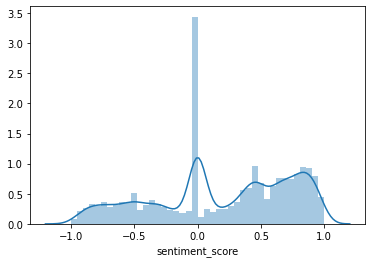

In [302]:
sns.distplot(df.sentiment_score)

In [303]:
emojis = df[df.emoji_frequency>60].groupby('top_emoji')[['sentiment_score', 'emoji_frequency']].mean()
emojis.head()

,sentiment_score,emoji_frequency
top_emoji,,
♥,0.782895,83
✨,0.583649,274
❤,0.136461,178
🌊,0.219962,66
🌎,0.083548,65


In [304]:
emojis.to_csv("emojis.csv")

In [305]:
emojis.index.nunique()

139

In [306]:
emojis.emoji_frequency.describe()

count     139.000000
mean      275.388489
std       455.130870
min        62.000000
25%        91.500000
50%       147.000000
75%       287.000000
max      4082.000000
Name: emoji_frequency, dtype: float64

### Write in some blurb here about the stuff above (amount of emojis, mean freq of emoji, etc) once I have all my data

In [307]:
neg_emojis = emojis[emojis.sentiment_score < -.1].index.unique()
net_emojis = emojis[(emojis.sentiment_score >= -.1) & (emojis.sentiment_score <= .1)].index.unique()
pos_emojis = emojis[emojis.sentiment_score > .1].index.unique()

In [308]:
negative = df.loc[df['top_emoji'].isin(neg_emojis)]
neutral = df.loc[df['top_emoji'].isin(net_emojis)]
positive = df.loc[df['top_emoji'].isin(pos_emojis)]

print(f"Negative length: {len(negative)}")
print(f"Neutral length: {len(neutral)}")
print(f"Postive length: {len(positive)}")

Negative length: 7931
Neutral length: 6975
Postive length: 23373


In [309]:
negative.top_emoji.value_counts()[:15]

😭    2933
🔥    1000
💀     513
👻     505
😩     413
😬     220
😐     208
😱     207
😡     205
😢     196
😒     182
💥     172
😞     160
😫     138
🤢     134
Name: top_emoji, dtype: int64

In [310]:
neutral.top_emoji.value_counts()[:15]

🤔    658
🙄    605
😔    561
🤦    479
🤷    470
👇    437
🥴    397
😳    379
💔    312
💯    245
🙃    205
😏    185
😤    164
🤡    156
🗣    147
Name: top_emoji, dtype: int64

In [311]:
positive.top_emoji.value_counts()[:15]

😂    4082
🤣    1553
🥺    1085
😍     790
🎃     729
🙏     656
🥰     646
👀     602
🚨     531
💜     477
😊     461
😁     436
💕     421
👍     382
💙     372
Name: top_emoji, dtype: int64

From the above, I will select some emojis to have as my "target values". My model won't be able to predict any emoji from the entire list of them, as that would greatly increase the difficulty of the classification. Would likely need far, far more data than I have for each emoji in order for something like that to work.

In [312]:
test = list(negative.top_emoji.value_counts()[:10].index) \
+ list(neutral.top_emoji.value_counts()[:10].index) \
+ list(positive.top_emoji.value_counts()[:10].index)

In [313]:
test

['😭',
 '🔥',
 '💀',
 '👻',
 '😩',
 '😬',
 '😐',
 '😱',
 '😡',
 '😢',
 '🤔',
 '🙄',
 '😔',
 '🤦',
 '🤷',
 '👇',
 '🥴',
 '😳',
 '💔',
 '💯',
 '😂',
 '🤣',
 '🥺',
 '😍',
 '🎃',
 '🙏',
 '🥰',
 '👀',
 '🚨',
 '💜']

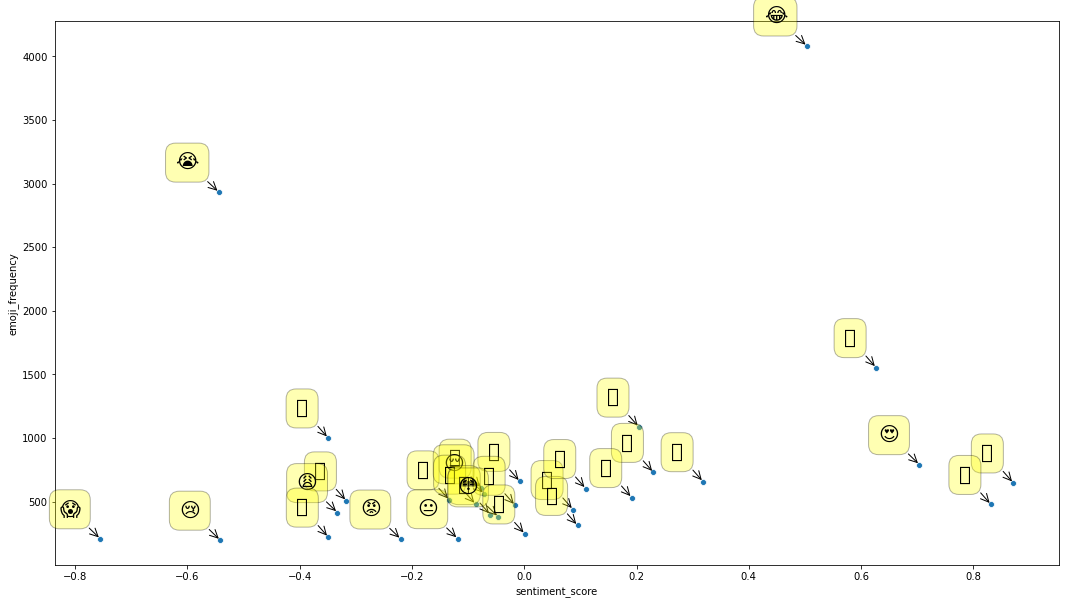

In [314]:
top30_emojis = emojis.loc[test]
plt.figure(figsize = (18,10))
sns.scatterplot(x=top30_emojis.sentiment_score, y=top30_emojis.emoji_frequency)
labels = list(top30_emojis.index)
for label, x, y in zip(labels, top30_emojis.sentiment_score, top30_emojis.emoji_frequency):
    plt.annotate(label, xy = (x, y), xytext = (-20, 20), textcoords = 'offset points', ha = 'right',
                 va = 'bottom', bbox = dict(boxstyle='round,pad=.5', fc='yellow', alpha=.3),
                 arrowprops = dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
                 fontname='Segoe UI Emoji', fontsize=20)
plt.show()

In [251]:
labels[0]+'e'

'😭e'